<a href="https://colab.research.google.com/github/jonhyuk0922/05.High-Resolution-Daytime-Translation-Without-Domain-Labels/blob/master/05_High_Resolution_Daytime_Translation_Without_Domain_Labels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Ready

##1-1. Google Drive mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/05.High-Resolution Daytime Translation Without Domain Labels/HiDT

import sys
sys.path.append('./HiDT')

/content/drive/MyDrive/05.High-Resolution Daytime Translation Without Domain Labels/HiDT


##1-2. Library Import

In [ ]:
import torch
from PIL import Image #이미지 불러오기 
import matplotlib.pyplot as plt #이미지 찍어내기


from hidt.networks.enhancement.RRDBNet_arch import RRDBNet
from hidt.style_transformer import StyleTransformer
from hidt.utils.preprocessing import GridCrop, enhancement_preprocessing

##1-3. Load Style Transfer Model

1. Daytime translation : 사진의 시간대를 바꾸는 모델
2. Image enhancement(=Super resoultion) : 이미지 화질 향상 모델

* 모델이 라벨이 없었다는게 주목할 만한 점

In [ ]:
config_path = 'configs/daytime.yaml'
gen_weights_path = 'trained_models/generator/daytime.pt'
device = 'cpu:0'

style_transformer = StyleTransformer(
    config_path,
    gen_weights_path,
    inference_size=256, #output image size , 512로 바꾸면 4-5배 느림. 그래서 나중에 화질 향상해주는 모델이 있는 것이다.
    device=device
)

#2. Daytime translation : 사진의 시간대를 바꾸는 모델

##2-1. Load Test Image

(2048, 1162)


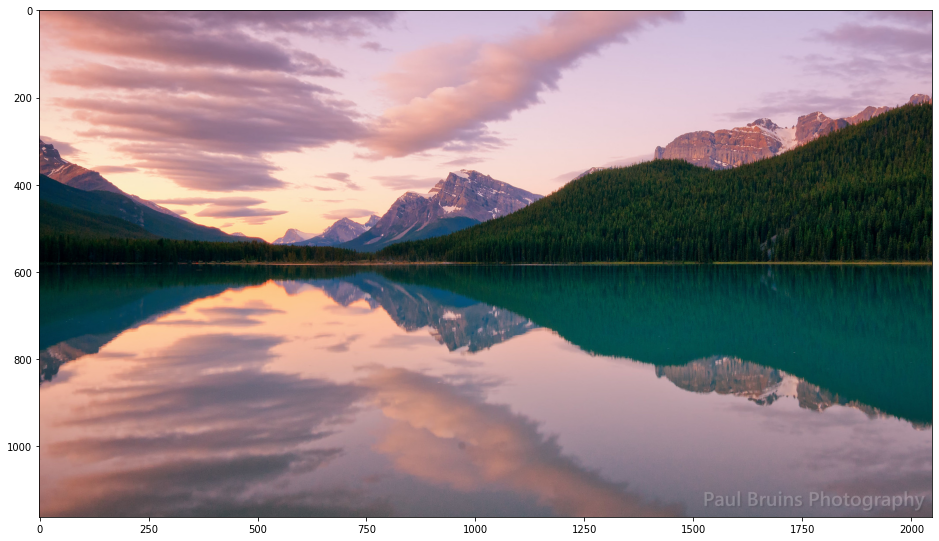

In [ ]:
img_path = 'images/daytime/content/1.jpg'

img = Image.open(img_path)

print(img.size)
plt.figure(figsize=(16,10))
plt.imshow(img)

#풍경만 있고 몇시에 어디서 찍은건지 레이블 없이 학습됐다. 
#이미지 사이즈 : (2048,1162)

##2-2. Load Style Parameters

In [ ]:
from pprint import pprint

with open('styles.txt') as f:
  styles = f.read()

styles = {style.split(',')[0]: torch.tensor([float(el) for el in style.split(',')[1][1:-1].split(' ')]) for style in styles.split('\n')[:-1]}

pprint(styles)

{'2minute': tensor([-0.3823,  0.5701, -0.9534]),
 '5minute': tensor([ 0.0393, -0.4581, -0.3173]),
 '5minutes2': tensor([-0.1544, -0.5920, -0.3295]),
 'another_night': tensor([ 0.0071, -1.3750, -0.3271]),
 'bluehour_bit_dark': tensor([-0.2956, -1.5699, -0.5350]),
 'bluehour_hard': tensor([ 0.4088, -1.6698,  0.2443]),
 'darknight': tensor([-0.4466, -1.3072, -0.3449]),
 'day': tensor([-0.2403,  0.4950,  0.2264]),
 'day2': tensor([-0.1528, -1.3118,  1.5012]),
 'hard_day': tensor([-0.0228, -0.3949,  0.8980]),
 'night': tensor([-0.4951, -1.0065, -1.0413]),
 'night2': tensor([-0.1531, -1.5918,  0.0850]),
 'nightmore': tensor([ 0.1075, -1.4487, -0.1843]),
 'onemorenight': tensor([ 0.2080, -1.5224, -0.0414]),
 'presunset': tensor([-0.2966,  0.5421, -0.6357]),
 'semihard_day': tensor([-0.1316,  0.0501,  0.5622]),
 'sunset_hard_harder': tensor([-0.5931,  1.0843, -1.2714]),
 'sunsetred': tensor([-0.1542,  0.1676, -1.7730])}


##2-3. Choose a Style

In [ ]:
style_to_transfer = styles['bluehour_hard'] #하늘이 파란색이 되는 시점

style_to_transfer = style_to_transfer.view(1,1,3,1).to(device)

##2-4. Inference

(256, 448, 3)


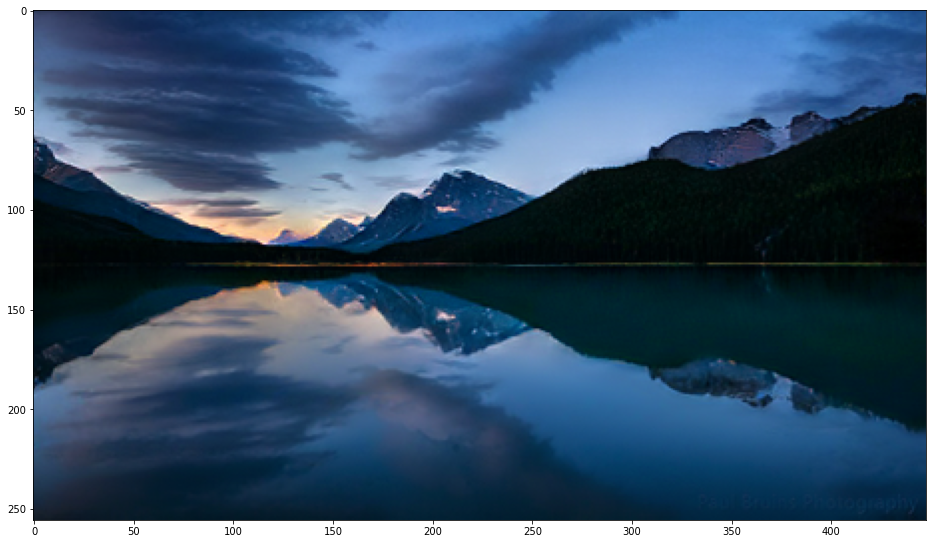

In [ ]:
with torch.no_grad():
  content_decomposition = style_transformer.get_content(img)[0]

  decoder_input = {
      'content': content_decomposition['content'],
      'intermediate_outputs':content_decomposition['intermediate_outputs'],
      'style':style_to_transfer
  }

  transferred = style_transformer.trainer.gen.decode(decoder_input)['images']

output_img = (transferred[0].cpu().clamp(-1,1).numpy().transpose(1,2,0) +1.)/2.

print(output_img.shape)
plt.figure(figsize=(16,10))
plt.imshow(output_img)

#inference size를 256으로 했기에 이미지 사이즈가 (256,448)로 많이 작아짐.

#3. Image enhancement(=Super resoultion) : 이미지 화질 향상 모델

##3-1. Load Image Enhance Network

In [ ]:
enhancer_weights = 'trained_models/enhancer/enhancer.pth'
enhancer = RRDBNet(in_nc=48,out_nc=3,nf=64,nb=5,gc=32).to(device)
enhancer.load_state_dict(torch.load(enhancer_weights))

crop_transform = GridCrop(4, 1, hires_size=256*4)
crops = [img for img in crop_transform(img)]

print(len(crops))

16


##3-2. Inference

* 왜 16개로 crop해놓고 0번 결과만 쓰는걸까?

In [ ]:
with torch.no_grad():
    crops = [i for i in crop_transform(img)]
    content_decomposition = style_transformer.get_content(crops)[0]

    decoder_input = {
        'content': content_decomposition['content'],
        'intermediate_outputs': content_decomposition['intermediate_outputs'],
        'style': style_to_transfer.repeat(16, 1, 1, 1)
    }

    transferred = style_transformer.trainer.gen.decode(decoder_input)['images']

    #enhancement
    padded_stack = enhancement_preprocessing(transferred, normalize=False)
    out = enhancer(padded_stack)

enhanced_output_img = (out.cpu()[0].clamp(-1, 1).numpy().transpose(1, 2, 0) + 1.) / 2.

(1024, 1792, 3)


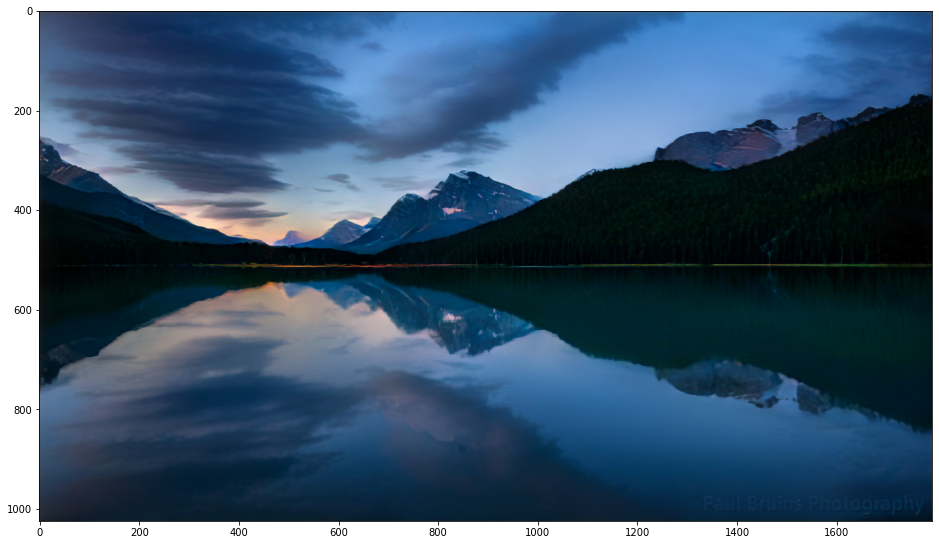

In [ ]:
print(enhanced_output_img.shape)
plt.figure(figsize=(16, 10))
plt.imshow(enhanced_output_img)

##3-3. Result Comparison

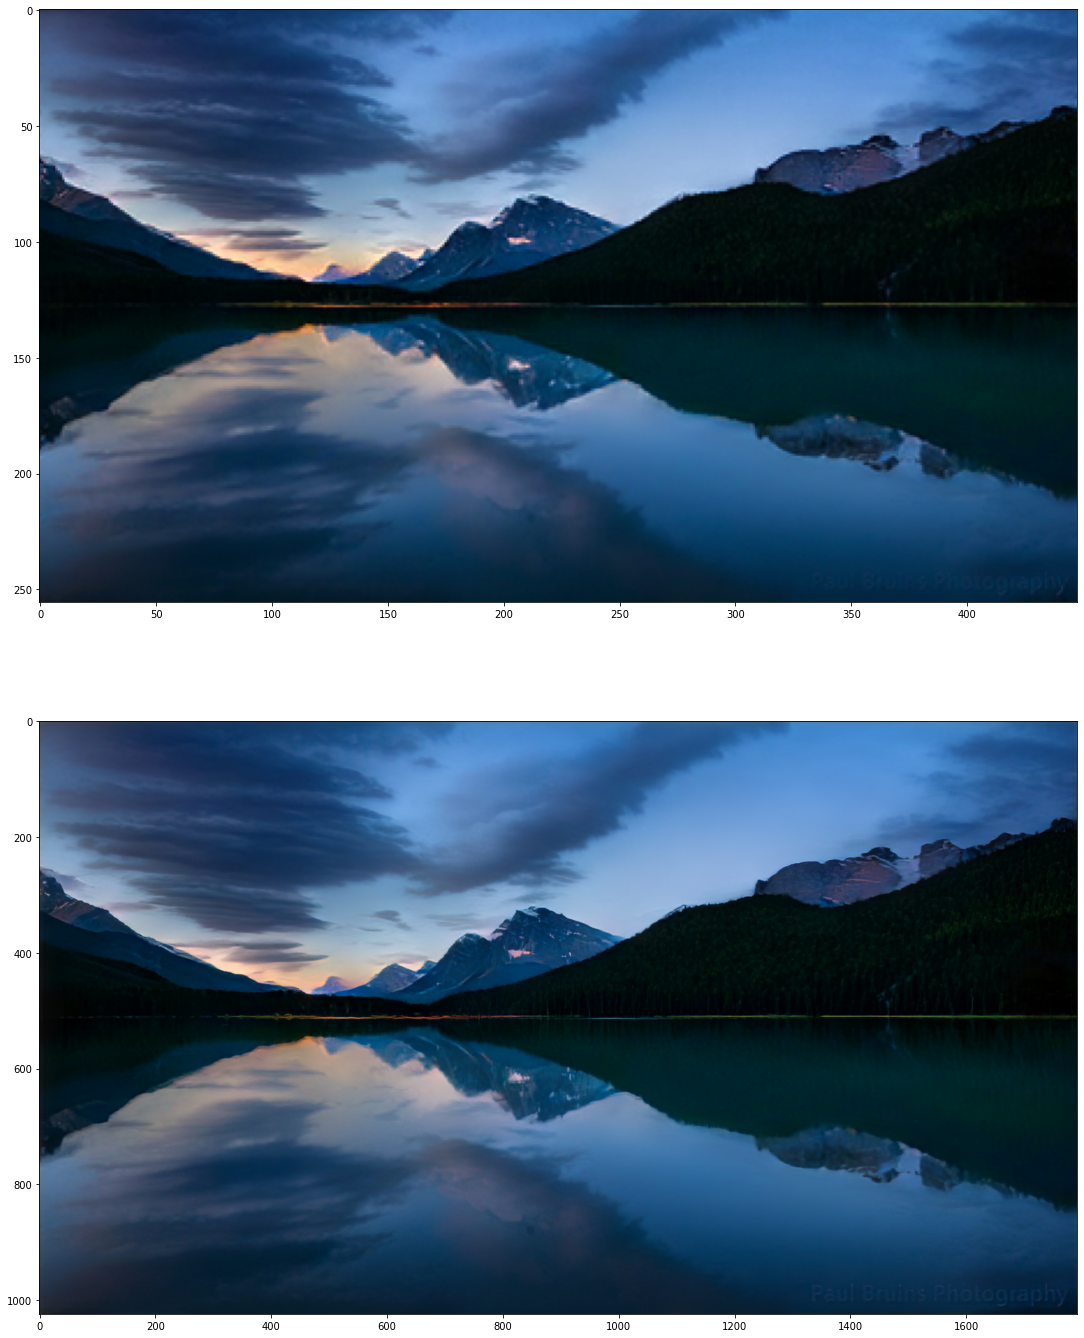

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(20, 24))
axes[0].imshow(output_img)
axes[1].imshow(enhanced_output_img)

#4. Functionalize

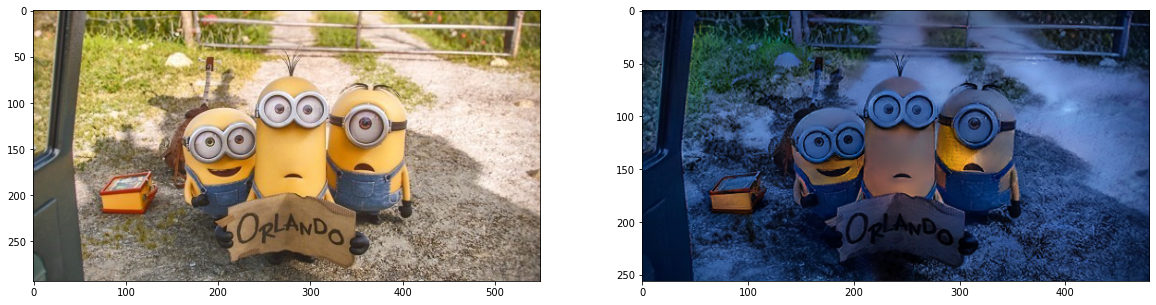

In [ ]:
def transfer(img, style):
    style_to_transfer = styles[style]
    style_to_transfer = style_to_transfer.view(1, 1, 3, 1).to(device)

    with torch.no_grad():
        content_decomposition = style_transformer.get_content(img)[0]

        decoder_input = {
            'content': content_decomposition['content'],
            'intermediate_outputs': content_decomposition['intermediate_outputs'],
            'style': style_to_transfer
        }

        transferred = style_transformer.trainer.gen.decode(decoder_input)['images']

    return (transferred[0].cpu().clamp(-1, 1).numpy().transpose(1, 2, 0) + 1.) / 2.
    
test_img = Image.open('images/test/미니언즈.jpeg')
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(test_img)
axes[1].imshow(transfer(test_img, style='bluehour_hard'))

In [ ]:
test_img = Image.open('images/test/백록담_종혁.jpeg')
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(test_img)
axes[1].imshow(transfer(test_img, style='sunset_hard_harder'))
#코타키나발루가서 못찍은 일몰사진을 이렇게 찍네 ..

UnidentifiedImageError: ignored

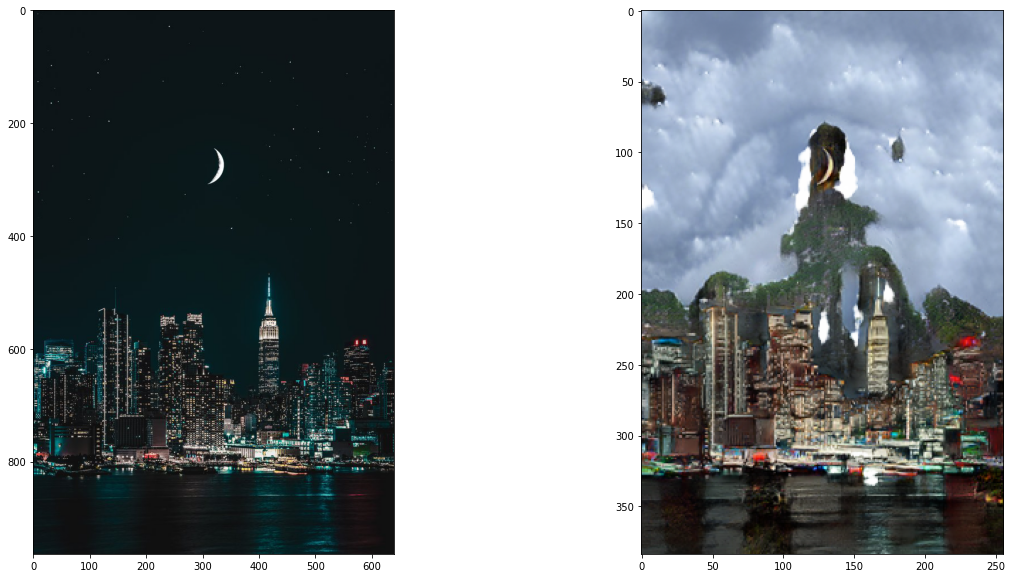

In [ ]:
test_img = Image.open('images/test/02.jpg')
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(test_img)
axes[1].imshow(transfer(test_img, style='semihard_day'))
#지구 종말인건가 ..

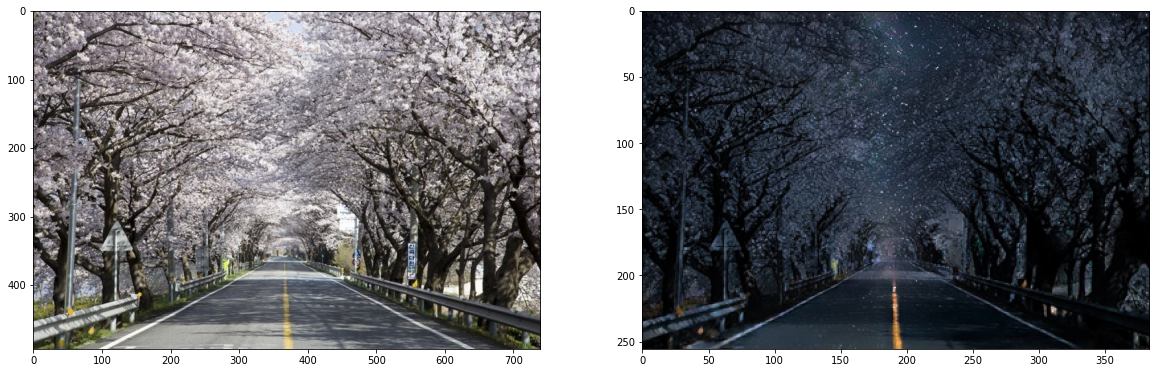

In [ ]:
test_img = Image.open('images/test/봄.jpeg')
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(test_img)
axes[1].imshow(transfer(test_img, style='darknight'))

In [ ]:
#idea : 여기서 사람이미지 손상을 아웃포커싱에서 썼던 마킹을 입혀보면 어떨까? 
#그러면 다음엔 아웃포커싱해보고 입혀보자!
#낮 -> 밤은 가려주는 거라 괜찮으나, 밤 -> 낮은 가려진걸 다시 나타내기 어려우므로 퀄리티 낮다.